<a href="https://colab.research.google.com/github/strawndri/tmcc-voculary/blob/feature%2Freconhecimento-texto/reconhecimento-texto/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Instalações e importações

## 1.1 Bibliotecas

In [1]:
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install langdetect

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,708 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
import pytesseract as pt
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from langdetect import detect

In [3]:
!mkdir tessdata

In [4]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

--2023-09-02 10:35:46--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2023-09-02 10:35:46--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2023-09-02 10:35:46--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

## 1.2 Imagens

In [61]:
artigo = 'imagens/artigo.png'
codigo = 'imagens/codigo.png'
nota_fiscal = 'imagens/nota_fiscal.png'
pagina = 'imagens/pagina.jpg'
pagina_2 = 'imagens/pagina_2.jpg'
pagina_3 = 'imagens/pagina_3.jpg'
pagina_4 = 'imagens/pagina_4.jpg'
pagina_5 = 'imagens/pagina_5.jpg'

# 2 Tratamento de imagens

In [6]:
def realcar_detalhes(imagem):
    img_redimensionada = cv2.resize(imagem, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    img_suavizada = cv2.GaussianBlur(img_redimensionada, (5, 5), 0)
    img_detalhes = 12 * cv2.subtract(img_redimensionada, img_suavizada)

    return cv2.add(img_redimensionada, img_detalhes)

In [7]:
def ajustar_brilho(imagem, threshold=128, alpha=1.5, beta=50):
    if np.mean(imagem) < threshold:
        return cv2.convertScaleAbs(imagem, alpha=alpha, beta=beta)
    return imagem

In [8]:
def binarizar(imagem):
    _, img_threshold = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if cv2.countNonZero(img_threshold) < (img_threshold.size / 2):
        return 255 - img_threshold
    return img_threshold

In [32]:
def avaliar_qualidade_ocr(imagem):
    resultado = pt.image_to_data(imagem, output_type=pt.Output.DICT)
    confiancas = [int(val) for val in resultado['conf'] if str(val).isdigit()]
    if confiancas:
        return sum(confiancas) / len(confiancas)
    return 0

In [57]:
def calcula_angulo(imagem):
    desfocado = cv2.GaussianBlur(imagem, (5, 5), 0)
    bordas = cv2.Canny(desfocado, 50, 150, apertureSize=3)
    linhas = cv2.HoughLines(bordas, 1, np.pi/180, 200)
    if linhas is None:
        return 0
    angulos = [np.degrees(theta) - 90 if np.degrees(theta) - 90 >= 0 else np.degrees(theta) - 90 + 180 for _, theta in linhas[:, 0]]
    return np.median(angulos)

def rotaciona_imagem(imagem, angulo):
    (h, w) = imagem.shape[:2]
    centro = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    rotacionada = cv2.warpAffine(imagem, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotacionada

def ajustar_orientacao(imagem):

    qualidade_desejada = 50.0
    imagem = cv2.imread(imagem)
    angulo_inicial = calcula_angulo(imagem)
    imagem_rotacionada = rotaciona_imagem(imagem, angulo_inicial)

    max_qualidade = avaliar_qualidade_ocr(imagem_rotacionada)

    if max_qualidade < qualidade_desejada:
      angulo_adicional = angulo_inicial + 180
      imagem_rotacionada = rotaciona_imagem(imagem, angulo_adicional)

    return imagem_rotacionada

# 3 Detecção e extração de textos

In [11]:
def determinar_psm(imagem):
    pixels_pretos = imagem.size - cv2.countNonZero(imagem)
    proporcao_preto = pixels_pretos / imagem.size

    if proporcao_preto > 0.2:
        return '6'
    else:
        return '1'

In [56]:
def detectar_idioma(imagem):
    codigos = {
        'en': 'eng',
        'pt': 'por'
    }

    try:
        cod_idioma = codigos[detect(pt.image_to_string(imagem))]
    except:
        cod_idioma = 'eng'

    return cod_idioma

In [13]:
def extrair_texto(imagem):

    imagem = ajustar_orientacao(imagem)
    imagem = realcar_detalhes(imagem)
    imagem = ajustar_brilho(imagem)
    img_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    img_binarizada = binarizar(img_cinza)

    psm_valor = determinar_psm(img_binarizada)
    cod_idioma = detectar_idioma(img_binarizada)

    resultado = pt.image_to_data(img_binarizada,
                               lang=cod_idioma,
                               config=f'--tessdata-dir tessdata --psm {psm_valor}',
                               output_type=pt.Output.DICT)

    texto_filtrado = [resultado['text'][i] for i in range(len(resultado['conf'])) if int(resultado['conf'][i] >= min_conf)]
    texto = ' '.join(texto_filtrado)

    return img_binarizada, texto

# 4 Testes de OCR

In [64]:
min_conf = 50 #@param {type: 'slider', min:0,max: 100}

## 4.1 Trecho de artigo

In [ ]:
imagem, texto = extrair_texto(artigo)
cv2_imshow(imagem)
print(texto)

## 4.2 Trecho de código do Visual Studio Code

In [ ]:
imagem, texto = extrair_texto(codigo)
cv2_imshow(imagem)
print(texto)

## 4.3 Nota fiscal

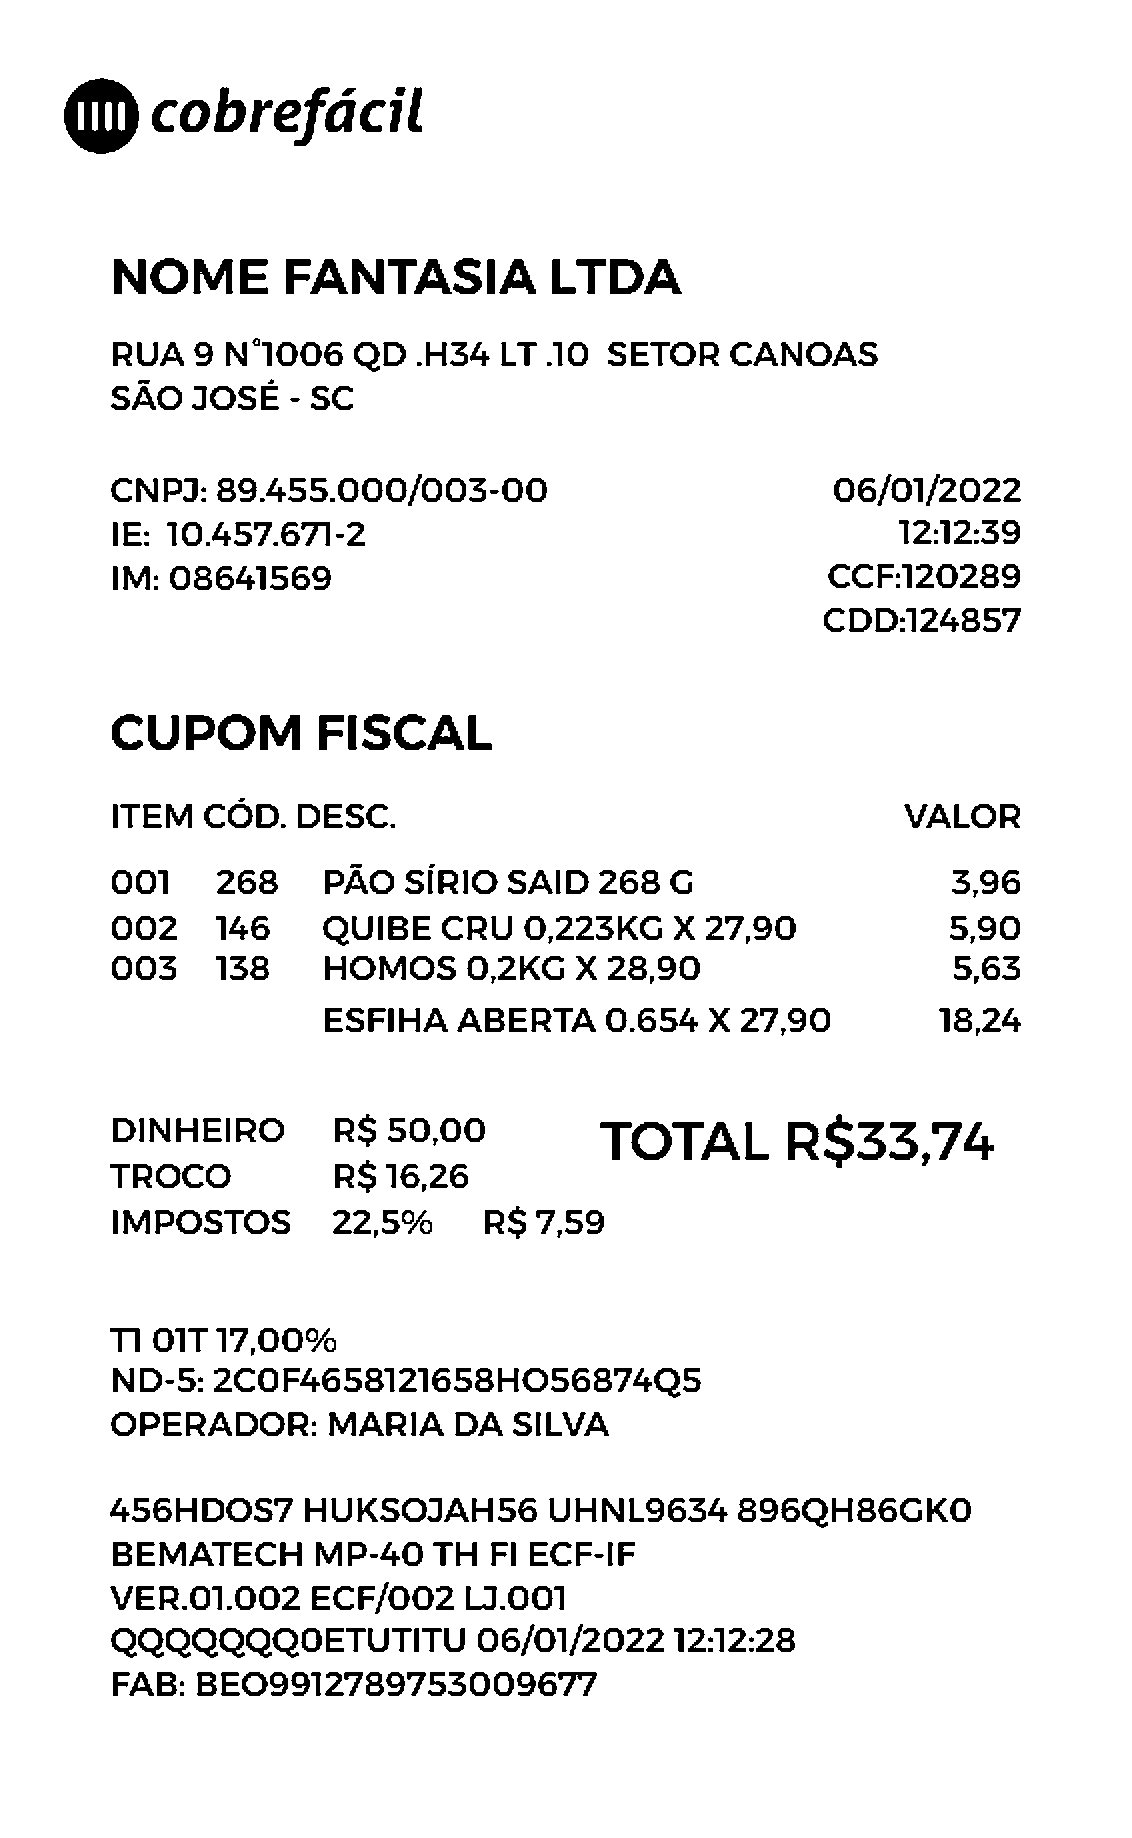

@ NOME FANTASIA LTDA RUA 9 N"1006 QD .H34 LT .10 SETOR CANOAS SAO JOSE - SC 89.455.000/003-00 06/01/2022 IE: 10.457.671-2 12:12:39 IM: 08641569 CCF:120289 CDD:124857 CUPOM FISCAL ITEM COD. DESC. VALOR 001 268 PAO SIRIOSAID 268G 3,96 002 146 QUIBE CRU 0,223KG X 27,90 5,90 003 138 HOMOS 0,2KG X 28,90 5,63 ESFIHA ABERTA 0.654 X 27,90 18,24 DINHEIRO R$ 50,00 TOTAL R$33,74 TROCO IMPOSTOS 225% R$759 T1 01T 17,00% ND-5: OPERADOR: MARIA DA SILVA 456HDOS7 HUKSOJAH56 UHNL9634 896QHB6GKO BEMATECH MP-40 TH ECF-IF VER.01.002 ECF/002 L1.001 QQQQQQQOETUTITU 06/01/2022 12:12:28 FAB: BEO9912789753009677


In [69]:
imagem, texto = extrair_texto(nota_fiscal)
cv2_imshow(imagem)
print(texto)

## 4.4 Página de um livro

O objetivo deste capítulo é analisar como a detecção de caracteres se comporta diante de imagens com diferentes orientações.

**O que é esperado?**
- Independente do ângulo de inclinação da imagem, o programa deverá ser capaz de rotacioná-la de modo que seu texto fique reto e esteja organizado de cima para baixo.

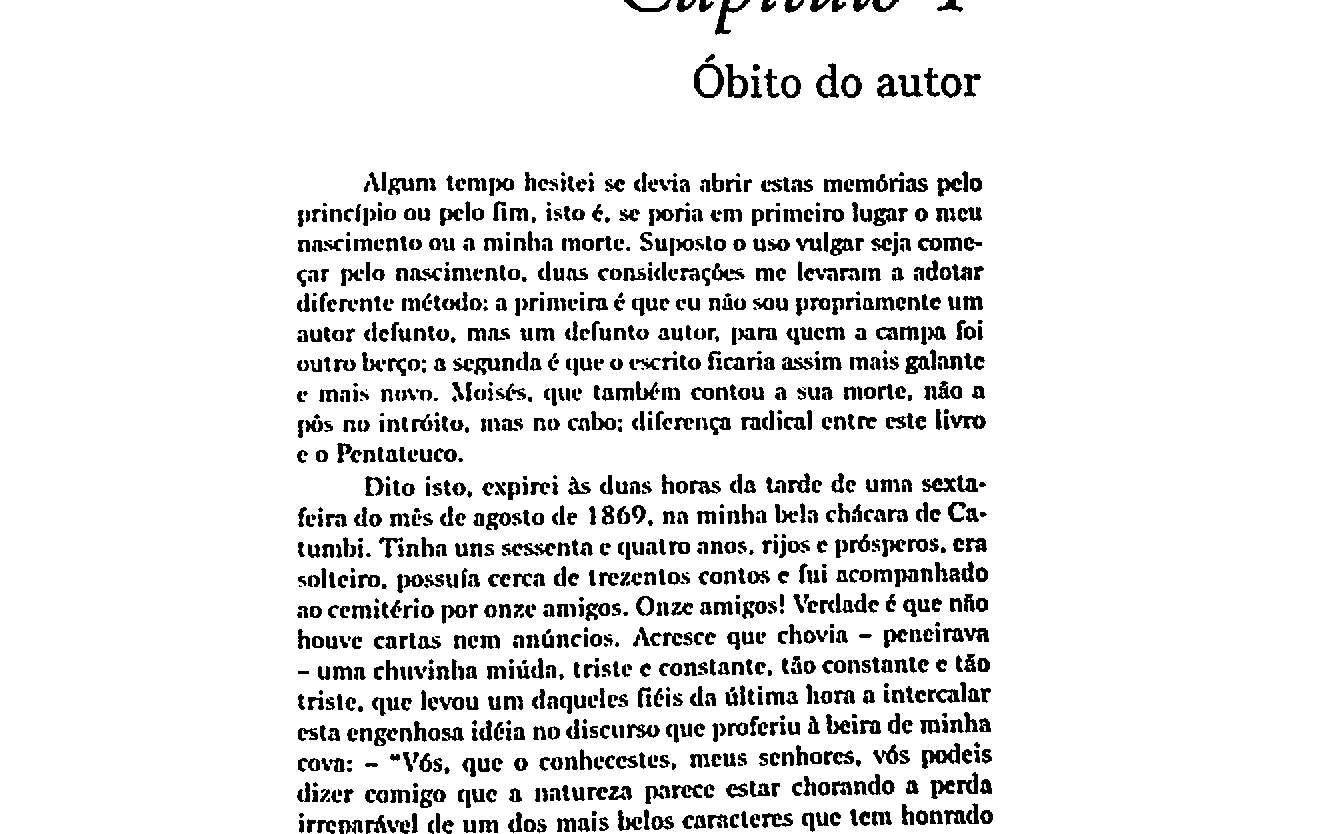

vvvlvavvvv . Óbito do autor Algum tempo hesitei se devia abrir estas memórias pelo princípio ou pelo fim, isto é, se poria em primeiro o meu nascimento ou a minha morte. Suposto o uso vulgar seja come- çar pelo nascimento, considerações me levaram a adotar diferente método: a primeira é que cu não sou um autar defunto, mas um defunto autor, para quem a campa foi ovutro berço: a segunda é que o escrito ficaria assim mais galante e mais novo. Moisés, que também contou a sua morte, não a pôs no intróito, mas no cobo; diferença radical entre este livro € o Pentateuco. Dito isto, expirei às duas horas da tarde de uma sexta- feira do mês de agosto de 1869, na minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos, rijos e prósperos, era solteiro, possuía cerca de trezentos contos e fui ao cemitério por onze amigos. Onze amigos! Verdade é que não houve cartas nem anúncios. Acresce que chovia — peneirava - umn chuvinha miúda, triste e constante, tão constante e tão que levou um daqu

In [65]:
imagem, texto = extrair_texto(pagina)
cv2_imshow(imagem)
print(texto)

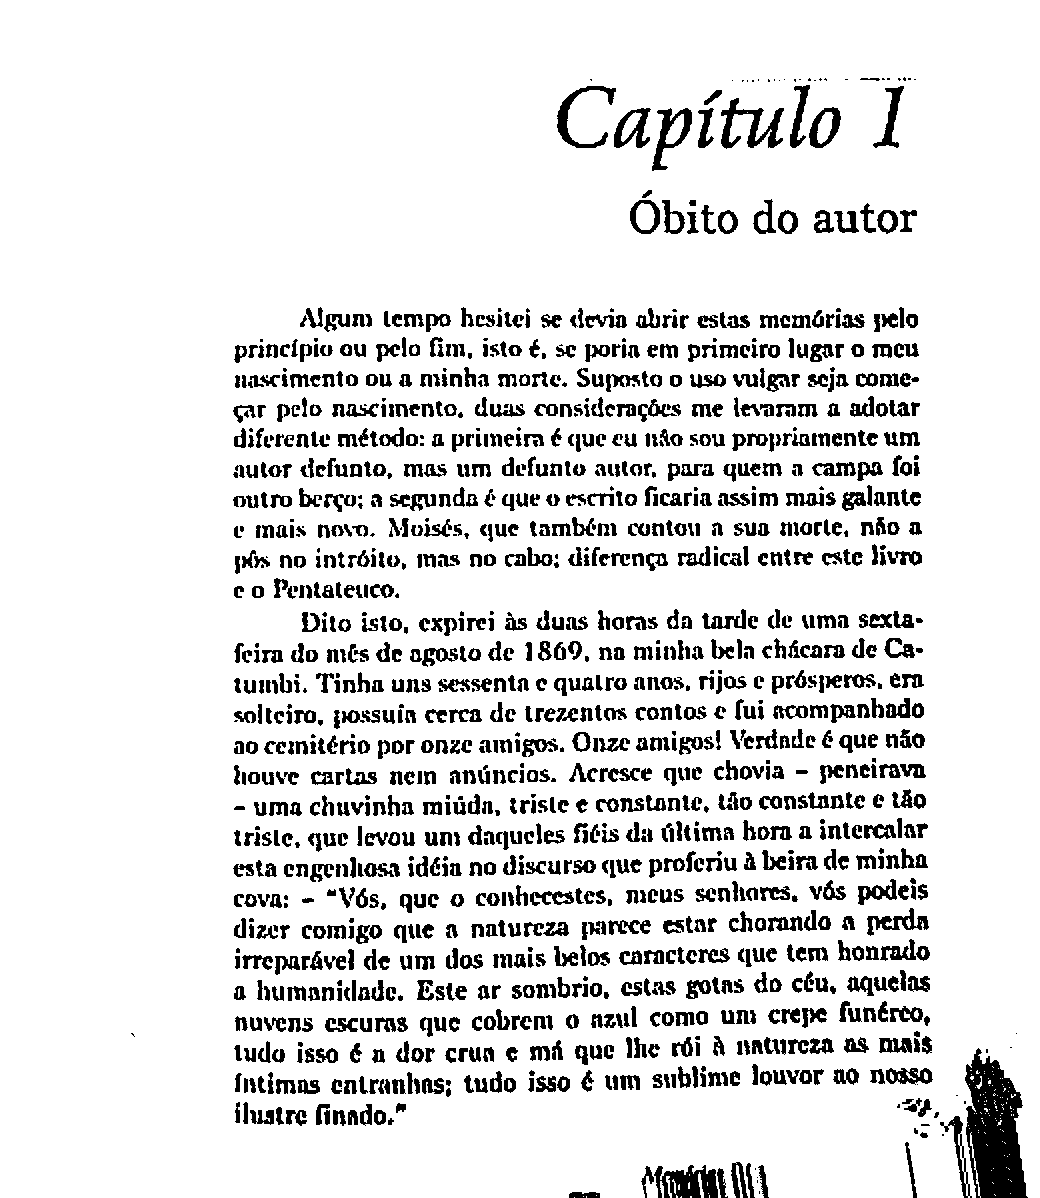

Óbito do autor Algum tempo se devia abrie estas memórias pelo princípio ou pelo fim, isto é, se porin em primeiro lugar o meu nascimento ou a minha morte. Suposto o uso vulgar seja come- pelo nascimento, duas considerações me tevaram a adotar diferente método: a primeira é que eu sou proprinmente um autor defunto, mas um defunto autor, para quem a campa foi berço; à segundo é que o escrito ficaria assim mais galante e mais novo. Moisés, que também contou à morte, não a pôs no intróito, mas no cabo; diferença radical entre este c o Pentateuco. Dito isto, expirei às duas horas da tarde de uma sexta- feira do mês de de 1869, na minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos, rijos e prósperos, em solteiro, possuin cerca de trezentos contos e acompanhado ao cemitério por onze amigos. Onze amigos! Verdade é que não houve cartas nem anúncios. Acresce que chovia - penceiravo - uma chuvinha miúda, triste e tão constante e tão trisle, que levou um daqueles fiéis da última hor

In [66]:
imagem, texto = extrair_texto(pagina_2)
cv2_imshow(imagem)
print(texto)

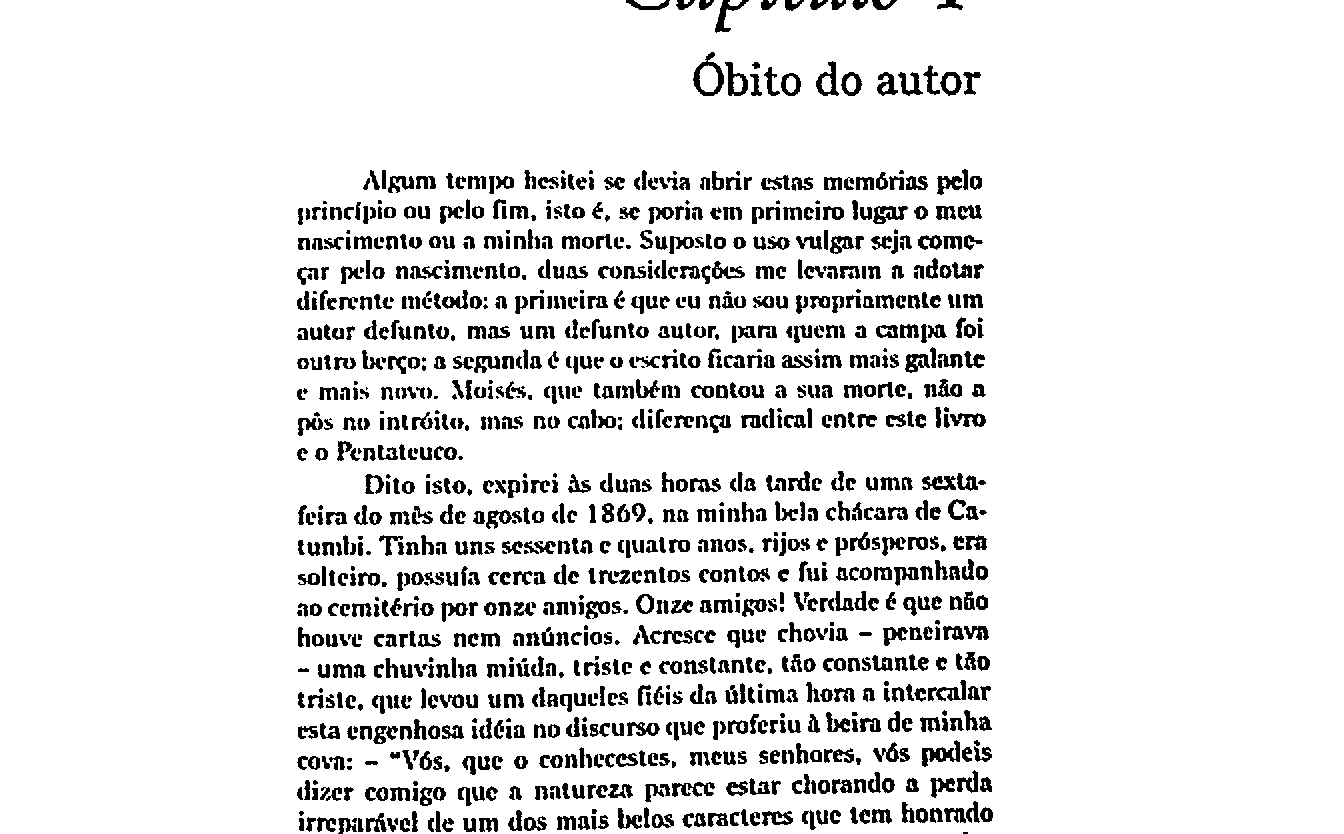

-s_/vvtl Óbito do autor Algum hesitei se devia abrir estas memórias pelo princípio ou pelo fim, isto é, se em primeiro Jugar o meu nascimento ou a minha morte. Suposto o uso vulgar seja come- pelo nascimento, considerações me levaram a adotar diferente método: a primeira é que eu não sou um autar defunto, mas um defunto autor, para quem a campa foi outro berço; 2 segunda é que o escrito ficaria assim mais galante e mais novo. Moisés, que também contou a sua morte, não a pôs no intróito, mas no cobo; diferença radical entre este € o Pentateuco. Dito isto, expirei às duas horas da tarde de uma sexta- feira do mês de agosto de 1869, na minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos. rijos e prósperos, era solteiro, possufa cerca de trezentos contos e fui acompanhado no cemitério por onze amigos. Onize amigos! Verdade é que não houve cartas nem anúncios. Acresce que chovia — peneirava - uma chuvinha miúda, triste e constante, tão constante e tão triste, que levou um daqu

In [67]:
imagem, texto = extrair_texto(pagina_4)
cv2_imshow(imagem)
print(texto)

In [ ]:
imagem, texto = extrair_texto(pagina_5)
cv2_imshow(imagem)
print(texto)